In [2]:
## Environment

### Main imports

# !pip install --upgrade "numpy==1.20.2"
import os
import numpy as np
import pandas as pd
import torch

### Plots

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from cycler import cycler

plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='grey', ls=':')
plt.rc('font', family='serif')
plt.rc('axes', prop_cycle=cycler(color='bmrcgyk'))
plt.rc('image', cmap='gist_rainbow')  # gist_rainbow
plt.rc('savefig', bbox='tight', pad_inches=0.1, format='pdf')
# set_matplotlib_formats('png')

### Also

rs = {'random_state': 0}
rng = np.random.default_rng(seed=0)

# Metrics, visualization

In [3]:
def bins_reliability_binary(y_true, y_confs, n_bins=10):
    '''
    Args:
        y_true: np.array (n,) of 0 and 1, real classes
        y_confs: np.array (n,), predicted probabilities of positive class
        n_bins: int, number of bins
    
    Returns:
        bin_confs: np.array (n,), mean confidence for each bin
        bin_accs: np.array (n,), frequency of positives for each bin
        weights: np.array (n,), normalized number of samples for each bin
    '''
    bins = np.linspace(0, 1, n_bins + 1)
    # [0, 0.1), [0.1, 0.2), ..., [0.9, 1.0 + eps)
    bins[-1] = 1 + 1e-10
    # find which bin each sample is assigned to
    bin_inds = np.digitize(y_confs, bins, right=False) - 1
    # count number of samples in each bin
    total = np.bincount(bin_inds, minlength=n_bins)
    # find mean confidence for each bin
    bin_confs = np.bincount(bin_inds, y_confs, minlength=n_bins)
    np.divide(bin_confs, total, out=bin_confs, where=total!=0)
    # find accuracy for each bin
    bin_accs = np.bincount(bin_inds, y_true, minlength=n_bins)
    np.divide(bin_accs, total, out=bin_accs, where=total!=0)
    weights = total / total.sum()
    return bin_confs, bin_accs, weights

def bins_reliability_multiclass(true_classes, confs, n_bins=10):
    '''
    Args:
        true_classes: np.array (n,) of integers in range(0, n_classes)
        confs: np.array (n, n_classes) of predicted probabilities
        n_bins: int, number of bins
    
    Returns:
        bin_confs: np.array (n,), mean confidence for each bin
        bin_accs: np.array (n,), accuracy for each bin
        weights: np.array (n,), normalized number of samples for each bin
    '''
    is_correct = (true_classes == confs.argmax(axis=1))
    prediction_confs = confs.max(axis=1)
    return bins_reliability_binary(is_correct, prediction_confs, n_bins)

In [91]:
from scipy.special import softmax
from torch.nn.functional import cross_entropy as NLL_logits
from sklearn.metrics import log_loss as NLL_probs


def ECE(bin_confs, bin_accs, weights):
    '''
    Args (returns from bins_reliability):
        bin_confs: np.array (n,), mean confidence for each bin
        bin_accs: np.array (n,), accuracy for each bin
        weights: np.array (n,)

    Returns:
        ece: expected calibration error
    '''
    diffs = np.abs(bin_confs - bin_accs)
    ece = np.average(diffs, weights=weights)
    return ece

def MCE(bin_confs, bin_accs, weights=None):
    '''
    Args (returns from bins_reliability):
        bin_confs: np.array (n,), mean confidence for each bin
        bin_accs: np.array (n,), accuracy for each bin
        weights: np.array (n,), unused

    Returns:
        mce: maximum calibration error
    '''
    diffs = np.abs(bin_confs - bin_accs)
    mce = diffs.max()
    return mce

def all_metrics(true_classes, confs=None, logits=None, n_bins=10, mul=100,
                return_rel=False):
    '''
    Args:
        true_classes: np.array (n,) of integers in range(0, n_classes)
        confs: np.array (n, n_classes) of predicted probabilities
        logits: np.array (n, n_classes) — if confs is None, softmax will
                be applied to logits to get probabilities
        n_bins: int, number of bins (for computing binning metrics)
        mul: float, multiplier for metrics with values in range [0, 1],
             default is 100
        return_rel: bool, whether to return (bin_confs, bin_accs, weights) - 
                    returns of bins_reliability_multiclass, default is False
    At least one of 'confs' and 'logits' should be provided!
    
    Returns:
        dictionary with metrics:
            'ACC': accuracy times mul,
            'ECE': expected calibration error times mul,
            'MCE': maximum calibration error times mul,
            'NLL': negative log likelihood,
            'BS': Brier score
        rel: tuple (check Args)
    '''
    if confs is None:
        confs = softmax(logits, axis=1)
    metrics = {}
    metrics['ACC'] = (confs.argmax(axis=1) == true_classes).mean() * mul
    rel = bins_reliability_multiclass(true_classes, confs, n_bins)
    metrics['ECE'] = ECE(*rel) * mul
    metrics['MCE'] = MCE(*rel) * mul
    if logits is None:
        metrics['NLL'] = NLL_probs(true_classes, confs)
    else:
        metrics['NLL'] = NLL_logits(torch.from_numpy(logits),
                                    torch.from_numpy(true_classes)).item()
    if return_rel:
        return metrics, rel
    else:
        return metrics

In [92]:
def _hist_plot_adjust():
    pad = 0.00
    plt.xlim(-pad, 1 + pad)
    plt.ylim(-pad, 1 + pad)
    plt.xticks(np.linspace(0, 1, 6))
    plt.yticks(np.linspace(0.2, 1.0, 5))
    plt.gca().set_aspect('equal')
    plt.gca().tick_params(length=0)

def _reliability_plot(bin_confs, bin_accs, weights=None,
                      name='reliability plot', acc_label='bin accuracy',
                      show=True, path=None):
    '''
    Args:
        bin_confs: np.array (n,), mean confidence for each bin
        bin_accs: np.array (n,), accuracy for each bin or class frequencies
        weights: np.array (n,)
        name: str, plot title
        acc_label: str, meaning of bin_accs
        show: bool, if True, plt.show() will be called
        path: str, location to save figure, default is None

    '''
    n_bins = len(bin_confs)
    bins = np.linspace(0, 1, n_bins + 1)
    centers = (bins[:-1] + bins[1:]) / 2
    plt.bar(centers, bin_confs, color=(1, 0, 0, 0.5), edgecolor='black',
            label='bin confidence', width=1/n_bins)
    plt.bar(centers, bin_accs, color=(0, 0, 1, 0.5), edgecolor='black',
            label=acc_label, width=1/n_bins)
    if weights is not None:
        plt.bar(centers, weights, color=(0, 1.0, 0.5, 0.8), edgecolor='black',
                label='bin weight', width=0.5/n_bins)
    plt.plot([0, 1], [0, 1], color='silver', linestyle='--')
    plt.xlabel('confidence')
    #  plt.ylabel('accuracy') not only...
    plt.legend()
    plt.title(name)
    _hist_plot_adjust()
    if show:
        plt.show()
    if path is not None:
        plt.savefig(path)

def reliability_plot(true_classes, confs=None, logits=None, n_bins=10, **kwargs):
    '''
    Args:
        true_classes: np.array (n,) of integers in range(0, n_classes)
        confs: np.array (n, n_classes) of predicted probabilities
        logits: np.array (n, n_classes) — if confs is None, softmax will
                be applied to logits to get probabilities
        n_bins: int, number of bins (for computing binning metrics)
        kwargs: keyword arguments passed to _reliability_plot

    At least one of 'confs' and 'logits' should be provided!
    '''
    if confs is None:
        confs = softmax(logits, axis=1)
    rel = bins_reliability_multiclass(true_classes, confs, n_bins)
    _reliability_plot(*rel, **kwargs)

# Методы калибровки

## Бины

In [113]:
from functools import partial
from sklearn.isotonic import IsotonicRegression

class HistogramBinningBinary:
    def __init__(self, n_bins=10):
        self.n_bins = n_bins
        self.thetas = None
        self.bins = np.linspace(0, 1, n_bins + 1)
        self.bins[-1] += 1e-10

    def fit(self, y_confs, y_true):
        '''
        Args:
            y_confs: np.array estimated probabilities of positive class
            y_true: np.array of 0 and 1
        '''
        _, thetas, weights = bins_reliability_binary(y_true, y_confs,
                                                     n_bins=self.n_bins)
        # in case bin is empty, the probability won't be changed
        thetas[weights == 0] = -1
        self.thetas = thetas
    
    def transform(self, y_confs):
        '''
        Args:
            y_confs: uncalibrated estimated probability of positive class
        Returns:
            y_confs_calib: calibrated probabilities
        '''
        y_confs_calib = self.thetas[np.digitize(y_confs, self.bins) - 1]
        empty_bins = (y_confs_calib < 0)
        y_confs_calib[empty_bins] = y_confs[empty_bins]
        return y_confs_calib

class IRBinary(IsotonicRegression):
    '''
    Isotonic regression wrapper for binary calibration.
    '''
    def __init__(self):
        super().__init__(increasing=True, out_of_bounds='clip',
                         y_min=0.0, y_max=1.0)

class CalibratorOvR:
    def __init__(self, base, **kwargs):
        '''
        Args:
            base: class of binary calibrator
            kwargs: keyword arguments to initialize each calibrator
        '''
        self.base = partial(base, **kwargs)
        self.ovr_calibrators = []
    
    def fit(self, confs, true_classes):
        '''
        Args:
            confs: np.array (n, n_classes) of predicted probabilities (uncalibrated)
            true_classes: np.array (n,) of integers in range(0, n_classes)
        '''
        self.ovr_calibrators = []
        for class_ in range(confs.shape[1]):
            calibrator = self.base()
            calibrator.fit(confs[:, class_], (true_classes == class_).astype(int))
            self.ovr_calibrators.append(calibrator)
    
    def transform(self, confs):
        '''
        Args:
            confs: np.array (n, n_classes) of predicted probabilities
        Returns:
            calbrated_confs: np.array (n, n_classes) of calibrated probabilities
        '''
        cal_confs = np.stack([calibrator.transform(confs[:, class_]) for
            class_, calibrator in enumerate(self.ovr_calibrators)], axis=1)
        # cal_confs /= cal_confs.sum(axis=1, keepdims=True)
        return cal_confs

class HistogramBinningMulticlass(CalibratorOvR):
    def __init__(self, n_bins=10):
        super().__init__(HistogramBinningBinary, n_bins=n_bins)

class IsotonicRegressionMulticlass(CalibratorOvR):
    def __init__(self):
        super().__init__(IRBinary)

# Logits download

In [33]:
def get_logits(path):
    logitss = {}
    targets = None
    for fname in os.listdir(path):
        if fname == 'targets.txt':
            with open(os.path.join(path, fname), 'r') as fin:
                targets = np.array([int(target) for target in fin.read().split()])
        elif fname[-3:] == '.pt':
            logitss[fname[:-3]] = torch.load(os.path.join(path, fname)).numpy()
    return logitss, targets

In [100]:
path = '../input/calibration/logits/cifar100'
logitss, targets = get_logits(path)

=== shufflenetv2_x1_0 ===
Before calibration {'ACC': 72.58, 'ECE': 10.96366247020662, 'MCE': 22.323237773168046, 'NLL': 1.1679890155792236}
Histogram binning {'ACC': 74.46000000000001, 'ECE': 0.4350501752499116, 'MCE': 2.7844357390262724, 'NLL': 1.4180779128341265}
Isotonic regression {'ACC': 74.33, 'ECE': 0.2849171056598399, 'MCE': 4.34683169722557, 'NLL': 0.9452048729340371}


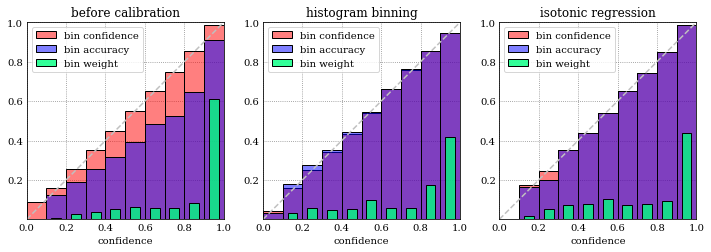

=== shufflenetv2_x2_0 ===
Before calibration {'ACC': 75.48, 'ECE': 7.51700291745365, 'MCE': 17.89006427061304, 'NLL': 0.9942768812179565}
Histogram binning {'ACC': 77.35, 'ECE': 0.5894022502254296, 'MCE': 6.836929768540832, 'NLL': 1.2689711835630852}
Isotonic regression {'ACC': 77.46, 'ECE': 0.3065463229268807, 'MCE': 9.23076942563057, 'NLL': 0.8379970010178489}


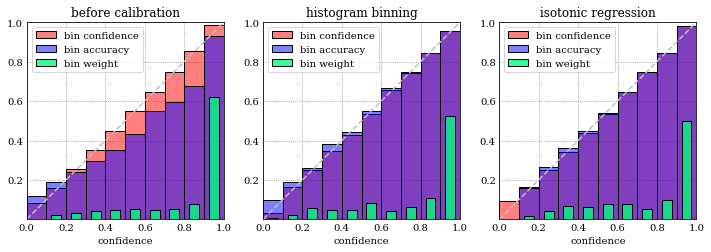

=== resnet56 ===
Before calibration {'ACC': 72.63, 'ECE': 14.18149338170886, 'MCE': 29.7055010120673, 'NLL': 1.2945834398269653}
Histogram binning {'ACC': 74.38, 'ECE': 0.5068552568768903, 'MCE': 4.675003651007163, 'NLL': 1.4401883637154196}
Isotonic regression {'ACC': 74.2, 'ECE': 0.30001434653997744, 'MCE': 3.202869816203946, 'NLL': 0.9289524133444531}


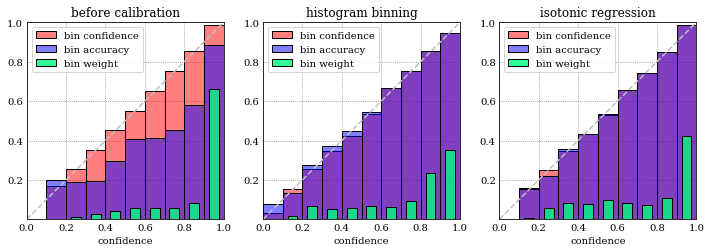

=== resnet32 ===
Before calibration {'ACC': 70.16, 'ECE': 13.278717060759671, 'MCE': 24.0185499440676, 'NLL': 1.3272653818130493}
Histogram binning {'ACC': 71.91, 'ECE': 0.50903256237495, 'MCE': 2.787307968948216, 'NLL': 1.531785134819264}
Isotonic regression {'ACC': 71.55, 'ECE': 0.43362014070152993, 'MCE': 4.741050319725209, 'NLL': 1.005642496292037}


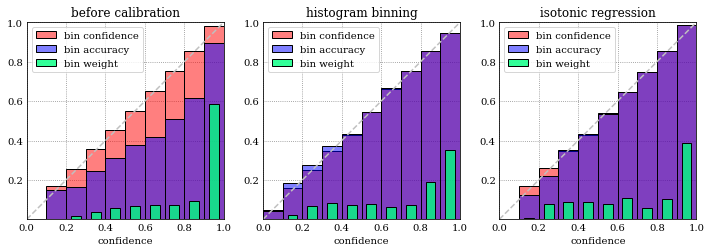

=== vgg13_bn ===
Before calibration {'ACC': 74.63, 'ECE': 13.133437340818343, 'MCE': 34.86130607466327, 'NLL': 1.2927604913711548}
Histogram binning {'ACC': 76.27000000000001, 'ECE': 0.5504423014342571, 'MCE': 4.328387887343221, 'NLL': 1.410944064770666}
Isotonic regression {'ACC': 76.02, 'ECE': 0.20108041733503737, 'MCE': 40.9845557063818, 'NLL': 0.9795490334547591}


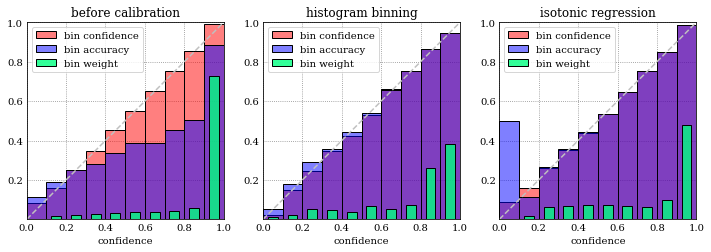

=== mobilenetv2_x1_0 ===
Before calibration {'ACC': 74.29, 'ECE': 11.153444432467229, 'MCE': 24.877850640387766, 'NLL': 1.069521188735962}
Histogram binning {'ACC': 76.53999999999999, 'ECE': 0.6111597153637874, 'MCE': 3.680090592993656, 'NLL': 1.31048613041934}
Isotonic regression {'ACC': 76.31, 'ECE': 0.18716576032340224, 'MCE': 1.4410780045980343, 'NLL': 0.8354293182959315}


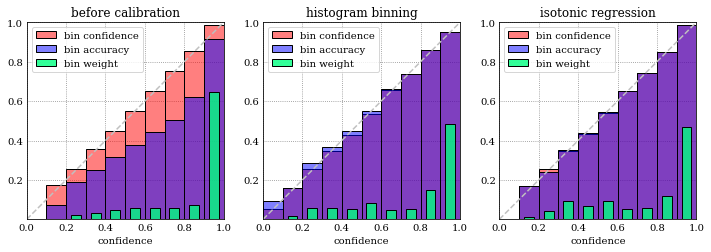

=== mobilenetv2_x0_5 ===
Before calibration {'ACC': 71.17, 'ECE': 11.909154390394686, 'MCE': 22.913648860795156, 'NLL': 1.1710031032562256}
Histogram binning {'ACC': 72.96000000000001, 'ECE': 0.29036240986610334, 'MCE': 6.3445237520932105, 'NLL': 1.4436991524559681}
Isotonic regression {'ACC': 73.06, 'ECE': 0.35450746357441043, 'MCE': 3.30235311662517, 'NLL': 0.9266657529379067}


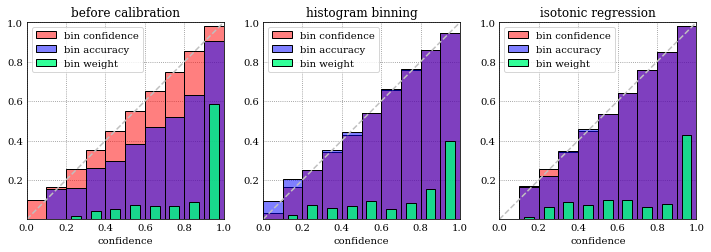

=== vgg16_bn ===
Before calibration {'ACC': 74.0, 'ECE': 18.87737523645162, 'MCE': 44.65071815404536, 'NLL': 1.6426622867584229}
Histogram binning {'ACC': 75.78, 'ECE': 0.47003811812506135, 'MCE': 7.0626230807581125, 'NLL': 1.5118633865727082}
Isotonic regression {'ACC': 75.39, 'ECE': 0.1697820963710539, 'MCE': 15.584415383636951, 'NLL': 1.0042064290191979}


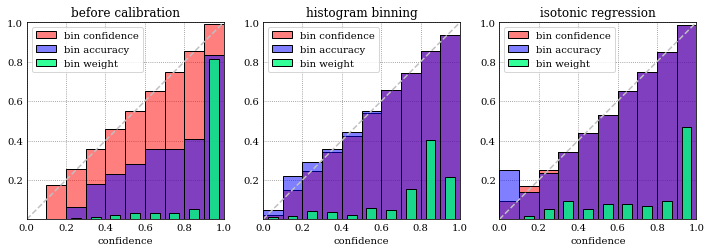

=== resnet44 ===
Before calibration {'ACC': 71.63000000000001, 'ECE': 14.161229904890055, 'MCE': 28.331676783136363, 'NLL': 1.313475251197815}
Histogram binning {'ACC': 73.48, 'ECE': 0.5042282464227965, 'MCE': 5.8052262566788695, 'NLL': 1.4877355762775468}
Isotonic regression {'ACC': 72.98, 'ECE': 0.3044272470474221, 'MCE': 3.477144945981139, 'NLL': 0.962523458735575}


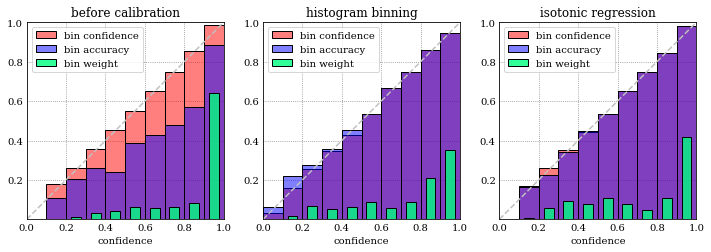

=== vgg19_bn ===
Before calibration {'ACC': 73.87, 'ECE': 19.678803376555447, 'MCE': 47.644248173551155, 'NLL': 1.8047444820404053}
Histogram binning {'ACC': 75.75, 'ECE': 0.47916311482150065, 'MCE': 6.134334415584453, 'NLL': 1.5237026111409957}
Isotonic regression {'ACC': 75.26, 'ECE': 0.15692352689802763, 'MCE': 3.610466451149935, 'NLL': 1.02288828976769}


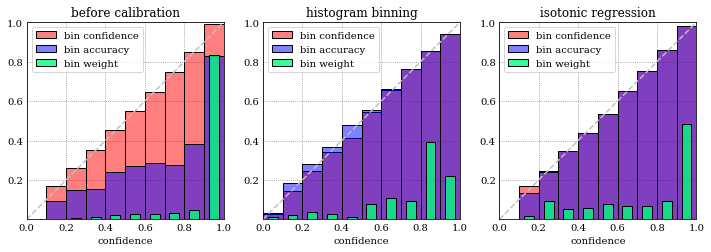

=== vgg11_bn ===
Before calibration {'ACC': 70.78, 'ECE': 15.214331752993168, 'MCE': 34.622953897752105, 'NLL': 1.4987601041793823}
Histogram binning {'ACC': 72.87, 'ECE': 0.5937788926212745, 'MCE': 3.5805809204568995, 'NLL': 1.589351876312399}
Isotonic regression {'ACC': 72.38, 'ECE': 0.23212205022573132, 'MCE': 9.013205952942371, 'NLL': 1.1206455953390804}


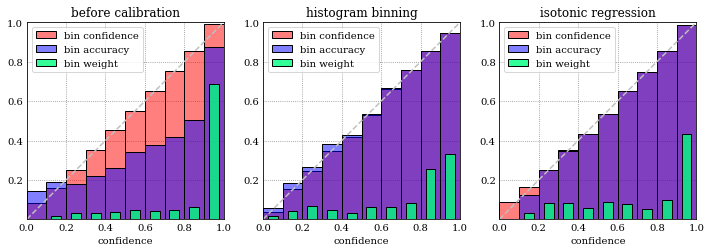

=== shufflenetv2_x0_5 ===
Before calibration {'ACC': 67.82000000000001, 'ECE': 12.253109535500407, 'MCE': 22.43510143774928, 'NLL': 1.297926664352417}
Histogram binning {'ACC': 70.12, 'ECE': 0.5536395592835386, 'MCE': 7.382481092511145, 'NLL': 1.5838673320335195}
Isotonic regression {'ACC': 70.13000000000001, 'ECE': 0.26484445884823477, 'MCE': 2.526145031054816, 'NLL': 1.045264109124546}


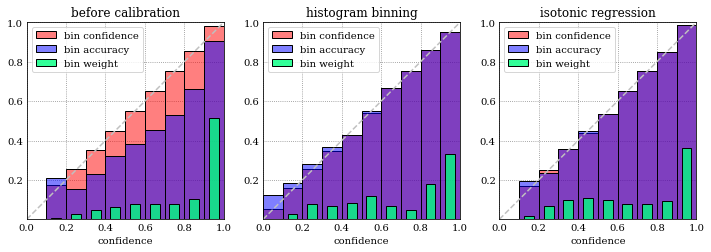

=== resnet20 ===
Before calibration {'ACC': 68.83, 'ECE': 10.33144568443298, 'MCE': 21.71480924226763, 'NLL': 1.2252498865127563}
Histogram binning {'ACC': 70.53, 'ECE': 0.5881783861948575, 'MCE': 2.4629072027781698, 'NLL': 1.5289806411435445}
Isotonic regression {'ACC': 70.6, 'ECE': 0.3989051244407904, 'MCE': 2.1425174304287005, 'NLL': 1.0084141718590807}


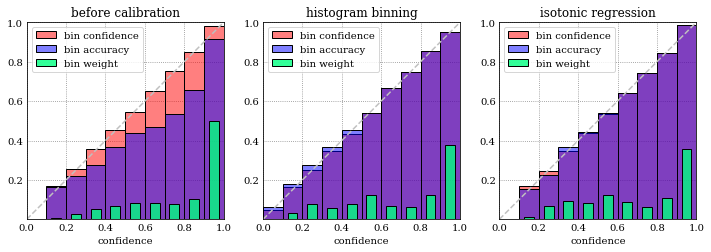

=== shufflenetv2_x1_5 ===
Before calibration {'ACC': 74.22999999999999, 'ECE': 9.424611502848572, 'MCE': 21.813162262359164, 'NLL': 1.074151635169983}
Histogram binning {'ACC': 75.78, 'ECE': 0.389219176708064, 'MCE': 4.200210440628224, 'NLL': 1.33612282362343}
Isotonic regression {'ACC': 75.98, 'ECE': 0.13501417614519645, 'MCE': 9.375, 'NLL': 0.8957303847352655}


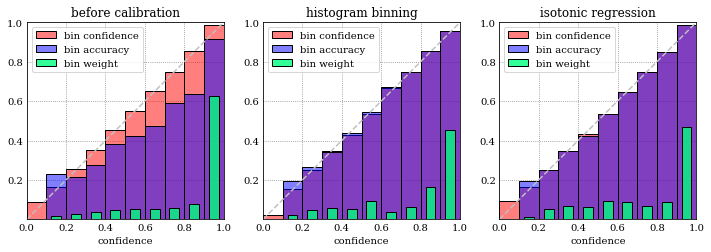

=== mobilenetv2_x1_4 ===
Before calibration {'ACC': 76.29, 'ECE': 9.833163440749049, 'MCE': 24.01708670624412, 'NLL': 0.9876667857170105}
Histogram binning {'ACC': 77.96, 'ECE': 0.5185885792593249, 'MCE': 5.3668580942603406, 'NLL': 1.2198987269840202}
Isotonic regression {'ACC': 77.91, 'ECE': 0.2613646159321083, 'MCE': 5.030065575348478, 'NLL': 0.7829314584203239}


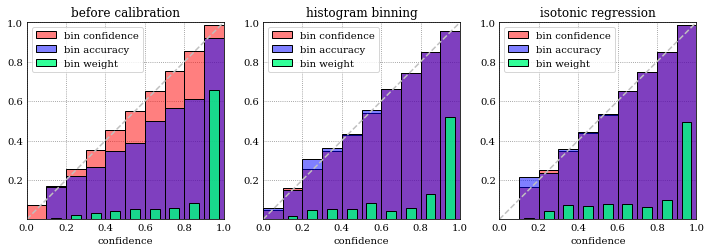

In [116]:
for name, logits in logitss.items():
    print(f'=== {name} ===')
    print('Before calibration', all_metrics(targets, logits=logits))
    plt.figure(figsize=(12, 5))
    plt.subplot(131)
    reliability_plot(targets, logits=logits, name='before calibration', show=False)
    confs = softmax(logits, axis=1)
    
    plt.subplot(132)
    calibrator = HistogramBinningMulticlass()
    calibrator.fit(confs, targets)
    calib_confs = calibrator.transform(confs)
    print('Histogram binning', all_metrics(targets, confs=calib_confs))
    reliability_plot(targets, confs=calib_confs, name='histogram binning', show=False)
    
    plt.subplot(133)
    calibrator = IsotonicRegressionMulticlass()
    calibrator.fit(confs, targets)
    calib_confs = calibrator.transform(confs)
    print('Isotonic regression', all_metrics(targets, confs=calib_confs))
    reliability_plot(targets, confs=calib_confs, name='isotonic regression', show=True)

In [63]:
from scipy.special import softmax
from sklearn.metrics import log_loss

log_loss(targets, softmax(logits, axis=1))

1.0422993476259175

# Проверка на SVM с двумя классами

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=20000, n_features=19,
                           n_informative=3, n_redundant=10,
                           random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)
model = LinearSVC(random_state=0, max_iter=10000)
_ = model.fit(X_train, y_train)


In [ ]:
y_val_confs = model.decision_function(X_val)
y_min = y_val_confs.min()
y_max = y_val_confs.max()

y_val_confs = (y_val_confs - y_min) / (y_max - y_min)
y_test_confs = model.decision_function(X_test)
y_test_confs = (y_test_confs - y_min) / (y_max - y_min)
y_test_confs = np.clip(y_test_confs, 0, 1)

In [ ]:
def binconf2mc(y_confs):
    return np.stack([1 - y_confs, y_confs], axis=1)

### No calibration

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
rel = bins_reliability_binary(y_test, y_test_confs, n_bins=10)
_reliability_plot(*rel, acc_label='class 1 frequency', show=False)
plt.subplot(122)
rel = bins_reliability_multiclass(y_test, binconf2mc(y_test_confs), n_bins=10)
_reliability_plot(*rel)

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
rel = bins_reliability_binary(y_val, y_val_confs, n_bins=10)
_reliability_plot(*rel, acc_label='class 1 frequency', show=False)
plt.subplot(122)
rel = bins_reliability_multiclass(y_val, binconf2mc(y_val_confs), n_bins=10)
_reliability_plot(*rel)

### Histogram binning (binary)

In [ ]:
calibrator = HistogramBinningBinary(n_bins=10)
calibrator.fit(y_val_confs, y_val)
y_val_confs_calib = calibrator.transform(y_val_confs)

plt.figure(figsize=(10, 5))
plt.subplot(121)
rel = bins_reliability_binary(y_val, y_val_confs_calib, n_bins=10)
_reliability_plot(*rel, acc_label='class 1 frequency', show=False)
plt.subplot(122)
rel = bins_reliability_multiclass(y_val, binconf2mc(y_val_confs_calib), n_bins=10)
_reliability_plot(*rel, show=False)

In [ ]:
calibrator = HistogramBinningBinary(n_bins=10)
calibrator.fit(y_val_confs, y_val)
y_test_confs_calib = calibrator.transform(y_test_confs)

plt.figure(figsize=(10, 5))
plt.subplot(121)
rel = bins_reliability_binary(y_test, y_test_confs_calib, n_bins=10)
_reliability_plot(*rel, acc_label='class 1 frequency', show=False)
plt.subplot(122)
rel = bins_reliability_multiclass(y_test, binconf2mc(y_test_confs_calib), n_bins=10)
_reliability_plot(*rel)

### Isotonic Regression (binary)

In [ ]:
calibrator = IRBinary()
calibrator.fit(y_val_confs, y_val)
y_val_confs_calib = calibrator.transform(y_val_confs)

plt.figure(figsize=(10, 5))
plt.subplot(121)
rel = bins_reliability_binary(y_val, y_val_confs_calib, n_bins=10)
_reliability_plot(*rel, acc_label='class 1 frequency', show=False)
plt.subplot(122)
rel = bins_reliability_multiclass(y_val, binconf2mc(y_val_confs_calib), n_bins=10)
_reliability_plot(*rel, show=False)

In [ ]:
calibrator = IRBinary()
calibrator.fit(y_val_confs, y_val)
y_test_confs_calib = calibrator.transform(y_test_confs)

plt.figure(figsize=(10, 5))
plt.subplot(121)
rel = bins_reliability_binary(y_test, y_test_confs_calib, n_bins=10)
_reliability_plot(*rel, acc_label='class 1 frequency', show=False)
plt.subplot(122)
rel = bins_reliability_multiclass(y_test, binconf2mc(y_test_confs_calib), n_bins=10)
_reliability_plot(*rel, show=False)

### Histogram binning (multiclass)

In [ ]:
calibrator_mc = HistogramBinningMulticlass(n_bins=10)
calibrator_mc.fit(binconf2mc(y_val_confs), y_val)
y_val_confs_calib_mc = calibrator_mc.transform(binconf2mc(y_val_confs))
y_val_confs_calib = y_val_confs_calib_mc[:, 1]

plt.figure(figsize=(10, 5))
plt.subplot(121)
rel = bins_reliability_binary(y_val, y_val_confs_calib, n_bins=10)
_reliability_plot(*rel, acc_label='class 1 frequency', show=False)
plt.subplot(122)
rel = bins_reliability_multiclass(y_val, y_val_confs_calib_mc, n_bins=10)
_reliability_plot(*rel, show=False)

In [ ]:
calibrator_mc = HistogramBinningMulticlass(n_bins=10)
calibrator_mc.fit(binconf2mc(y_val_confs), y_val)
y_test_confs_calib_mc = calibrator_mc.transform(binconf2mc(y_test_confs))
y_test_confs_calib = y_test_confs_calib_mc[:, 1]

plt.figure(figsize=(10, 5))
plt.subplot(121)
rel = bins_reliability_binary(y_test, y_test_confs_calib, n_bins=10)
_reliability_plot(*rel, acc_label='class 1 frequency', show=False)
plt.subplot(122)
rel = bins_reliability_multiclass(y_test, y_test_confs_calib_mc, n_bins=10)
_reliability_plot(*rel, show=False)

### Isotonic regression (multiclass)

In [ ]:
calibrator_mc = IsotonicRegressionMulticlass()
calibrator_mc.fit(binconf2mc(y_val_confs), y_val)
y_val_confs_calib_mc = calibrator_mc.transform(binconf2mc(y_val_confs))
y_val_confs_calib = y_val_confs_calib_mc[:, 1]

plt.figure(figsize=(10, 5))
plt.subplot(121)
rel = bins_reliability_binary(y_val, y_val_confs_calib, n_bins=10)
_reliability_plot(*rel, acc_label='class 1 frequency', show=False)
plt.subplot(122)
rel = bins_reliability_multiclass(y_val, y_val_confs_calib_mc, n_bins=10)
_reliability_plot(*rel, show=False)

In [ ]:
calibrator_mc = IsotonicRegressionMulticlass()
calibrator_mc.fit(binconf2mc(y_val_confs), y_val)
y_test_confs_calib_mc = calibrator_mc.transform(binconf2mc(y_test_confs))
y_test_confs_calib = y_test_confs_calib_mc[:, 1]

plt.figure(figsize=(10, 5))
plt.subplot(121)
rel = bins_reliability_binary(y_test, y_test_confs_calib, n_bins=10)
_reliability_plot(*rel, acc_label='class 1 frequency', show=False)
plt.subplot(122)
rel = bins_reliability_multiclass(y_test, y_test_confs_calib_mc, n_bins=10)
_reliability_plot(*rel, show=False)